# 1. Importación de paquetes

In [1]:
# Para la lectura y transformación de datos
import pandas as pd

# Para el manejo de vectores
import numpy as np

# Para la visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Para importar el modelo
!pip install xgboost
from xgboost import XGBClassifier

# Para realizar validación cruzada
from sklearn.model_selection import KFold, GridSearchCV

# Para evaluar las predicciones
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

# Para obtener la matriz de confusión
from sklearn.metrics import confusion_matrix

# Para guardar el modelo
import pickle

# 2. Lectura de los datasets procedentes del Notebook 3

In [2]:
df_train = pd.read_csv(r'../Dataset_con_transformaciones/df_train_after_notebook3.csv')
df_test = pd.read_csv(r'../Dataset_con_transformaciones/df_test_after_notebook3.csv')

Dividir los conjuntos de train y test en:
- Variables input 
- Variable objetivo

In [3]:
X_train, y_train = df_train.drop(columns=['output']), df_train.output
X_test, y_test = df_test.drop(columns=['output']), df_test.output

# 3. Generación del modelo 

In [4]:
# Variables

model = XGBClassifier(random_state=99)

param_grid = {
    'n_estimators': [10, 50, 100, 200], # Número de árboles en el ensamblado
    'max_depth': [5, 10, 25, 50], # Profundidad máxima de cada árbol
    'learning_rate': [0.01, 0.05, 0.1, 0.25], # Tasa de aprendizaje
    'grow_policy': ['depthwise', 'lossguide'], # Manera de crecimiento del árbol
    'subsample': [0.5, 0.8, 1.0] # Proporción de muestras utilizadas para entrenar cada árbol
}

model_file_name = "../Modelos/xgboost_model.sav"

Para hacer validación cruzada repetida, usar RepeatedKFold. Sin embargo, debido a limitaciones computacionales, se ha escogido hacer validación cruzada, para lo cual se usa KFold:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold

**¿Por qué escoger KFold para validación cruzada (y no elegir StratifiedKFold)?**

Como los datos no están desbalanceados, no hace falta utilizar StratifiedKFold. 

https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece

**¿Qué scoring escoger?**

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring

Como se vio en el módulo "Minería de datos y modelización predictiva - Aida Calviño", para problemas de clasificación, la técnica del área bajo la curva ROC (AUROC) es una medida bastante acertada a la hora de evaluar este tipo de algoritmos predictivos.

In [5]:
cv = KFold(n_splits=5, shuffle=True, random_state=99) # Validación cruzada

In [6]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=99, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     int...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, 

In [7]:
# Parámetros del mejor modelo
print(f"Mejor modelo: { grid_search.best_estimator_ }")
print(f"Mejores parámetros: { grid_search.best_params_ }")
print(f"Area bajo la curva ROC: { grid_search.best_score_ }")

Mejor modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=99, ...)
Mejores parámetros: {'grow_policy': 'depthwise', 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.5}
Area bajo la curva ROC: 0.9214140543670595


## 3.1. Modelo con los mejores parámetros 

In [8]:
selected_model = grid_search.best_estimator_

y_pred = selected_model.predict(X_test)

In [9]:
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.75      0.64      0.69        28
           1       0.73      0.82      0.77        33

    accuracy                           0.74        61
   macro avg       0.74      0.73      0.73        61
weighted avg       0.74      0.74      0.74        61



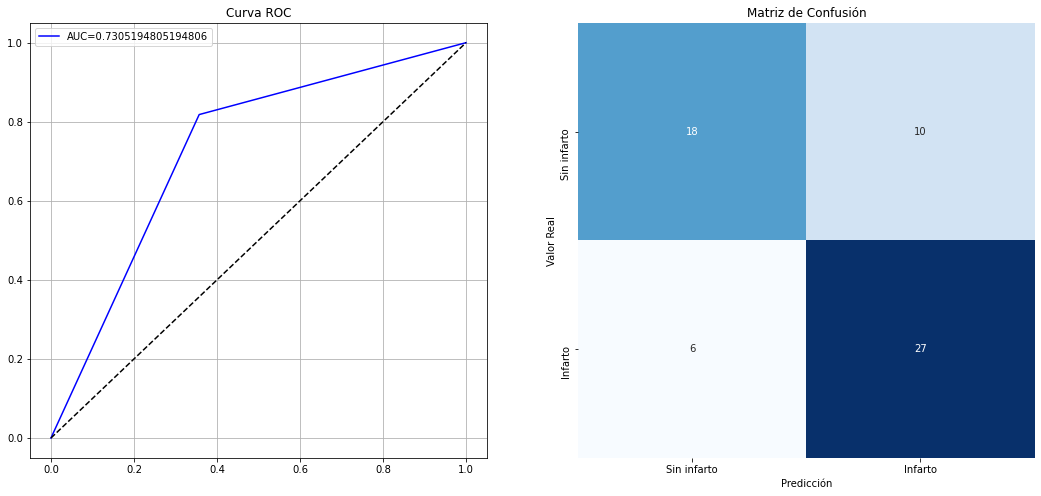

In [10]:
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
fpr, tpr, tr = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,'b',label="AUC="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Curva ROC')
plt.grid()
plt.legend(loc='best')

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
class_labels = ['Sin infarto', 'Infarto']
heatmap.set_xticklabels(class_labels)
heatmap.set_yticklabels(class_labels)
plt.title('Matriz de Confusión')

plt.show()

# Guardar el modelo resultante de este notebook

In [11]:
pickle.dump(selected_model, open(model_file_name, 'wb'))